In [5]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
import spconv.pytorch as spconv
import matplotlib.pyplot as plt
import mytools
import mymodels


# Select and load testing data

In [6]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [7]:
########################################
########################################
# Select Energy (40 or 50 keV)
Energy = 50
# Select diff amount (H or L)
Diff = 'H'
########################################
########################################


In [8]:
# Read pandas dataframe with all information about sparse testing tensors
st_info = pd.read_pickle('/home/majd/sparse_testing_tensors_'+str(Energy)+'keV_'+Diff+'diff/sparse_tensor_info.pk')
st_info.head()

,dir,offset,diff,energy
0,"[0.2024386198326871, 0.6729458302064713, 0.711...","[1.2269315413035626, -1.0297878003798282, -2.8...",0.0443,50
1,"[-0.11155777926156288, -0.6793289977470063, 0....","[2.2556262183844775, 1.8096210666976695, -0.76...",0.0443,50
2,"[-0.7813580837241936, -0.32087909183386143, 0....","[2.654029153218907, -0.7652375830249626, 0.259...",0.0443,50
3,"[0.8184578479379332, -0.01632955583650895, 0.5...","[-0.7794793420481543, -0.43791373544496887, -1...",0.0443,50
4,"[-0.6592374434861854, 0.2951645489992342, -0.6...","[-0.7052277672713678, -1.2819584548816922, -0....",0.0443,50


In [9]:
# Make custom dataset
MyDataset = mytools.CustomDataset(dir_loc='/home/majd/sparse_testing_tensors_'+str(Energy)+'keV_'+Diff+'diff/', st_info=st_info)

# Create DataLoader
batch_size = 64
test_dataloader = DataLoader(MyDataset, batch_size=batch_size, shuffle=True)

# Print tensor shapes
for X_plot, y_plot, offset_plot in test_dataloader:
    print(f"Shape of X [N, C, H, W, D]: {X_plot.shape}")
    print(f"Shape of y: {y_plot.shape} {y_plot.dtype}")
    print("Offsets: ", offset_plot.shape)
    break
    
#Record shape of voxel grid
grid_shape = X_plot.shape[1:4]
print("Voxel grid shape: " , grid_shape)


Shape of X [N, C, H, W, D]: torch.Size([64, 120, 120, 120, 1])
Shape of y: torch.Size([64, 3]) torch.float32
Offsets:  torch.Size([64, 3])
Voxel grid shape:  torch.Size([120, 120, 120])


In [10]:
Losses = []

for alpha in [1,2,4,5]:
    
    model_CNN = torch.load('../3D_Heteroscedastic_Convnet_models/3D_CNN_alpha_'+str(alpha)+'.pt').to(device)
    v_pred_CNN, v_true_CNN, off_true_CNN = mytools.test_CNN_alpha(test_dataloader,model_CNN,device)
    
    CNN_Loss = mytools.CSloss(v_pred_CNN, v_true_CNN).item()
        
    Losses += [CNN_Loss]
    

    

In [11]:
# Load the regular CNN model
model_CNN = torch.load('../3D_Heteroscedastic_Convnet_models/3D_CNN.pt').to(device)
# Obtain predictions and labels
v_pred_CNN, v_true_CNN, off_true_CNN = mytools.test_CNN(test_dataloader,model_CNN,device)
# Compute the cosine similairity loss, we cannot make efficiency cuts here
CNN_Loss = mytools.CSloss(v_pred_CNN, v_true_CNN).item()


Text(0, 0.5, 'Cosine distance loss')

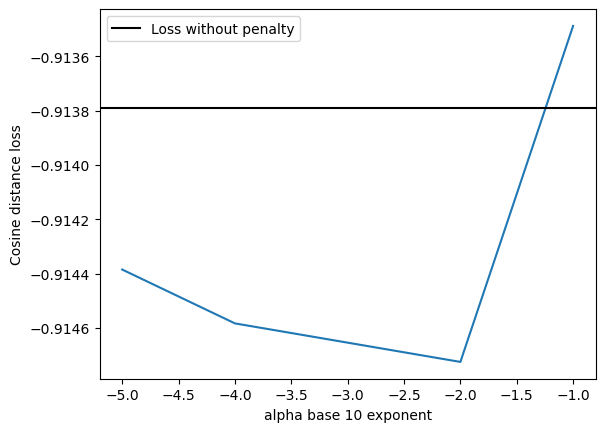

In [12]:
plt.plot([-1,-2,-4,-5],Losses)
plt.axhline(CNN_Loss,color = 'k', label="Loss without penalty")
plt.legend()
plt.xlabel("alpha base 10 exponent")
plt.ylabel("Cosine distance loss")

# Repeat analysis for all test sets simultaneously

In [41]:
Energies = [40,40,50,50]
Diffs = ["H","L","H","L"]

Losses = []

    
for alpha in [1,2,4,5]:
    
    
    v_pred = torch.tensor([])
    v_true =torch.tensor([])
    

    tot_samples = 0
    Loss = 0

    
    for Energy, Diff in zip(Energies,Diffs):
        
        st_info = pd.read_pickle('/home/majd/sparse_testing_tensors_'+str(Energy)+'keV_'+Diff+'diff/sparse_tensor_info.pk')
        
        # Make custom dataset
        MyDataset = mytools.CustomDataset(dir_loc='/home/majd/sparse_testing_tensors_'+str(Energy)+'keV_'+Diff+'diff/', st_info=st_info)

        # Create DataLoader
        batch_size = 64
        test_dataloader = DataLoader(MyDataset, batch_size=batch_size, shuffle=True)
        
        
        model_CNN = torch.load('../3D_Heteroscedastic_Convnet_models/3D_CNN_alpha_'+str(alpha)+'.pt').to(device)
        v_pred_CNN, v_true_CNN, off_true_CNN = mytools.test_CNN_alpha(test_dataloader,model_CNN,device)

        v_pred = torch.concat((v_pred,v_pred_CNN))
        v_true = torch.concat((v_true,v_true_CNN))
        
    Losses += [mytools.CSloss(v_pred, v_true).item()]


In [42]:



# Load the regular CNN model
model_CNN = torch.load('../3D_Heteroscedastic_Convnet_models/3D_CNN.pt').to(device)

v_pred = torch.tensor([])
v_true =torch.tensor([])

    
for Energy, Diff in zip(Energies,Diffs):
        
    st_info = pd.read_pickle('/home/majd/sparse_testing_tensors_'+str(Energy)+'keV_'+Diff+'diff/sparse_tensor_info.pk')
        
    # Make custom dataset
    MyDataset = mytools.CustomDataset(dir_loc='/home/majd/sparse_testing_tensors_'+str(Energy)+'keV_'+Diff+'diff/', st_info=st_info)

    # Create DataLoader
    batch_size = 64
    test_dataloader = DataLoader(MyDataset, batch_size=batch_size, shuffle=True)
        
        
    # Obtain predictions and labels
    v_pred_CNN, v_true_CNN, off_true_CNN = mytools.test_CNN(test_dataloader,model_CNN,device)
    
    v_pred = torch.concat((v_pred,v_pred_CNN))
    v_true = torch.concat((v_true,v_true_CNN))

Loss = mytools.CSloss(v_pred, v_true).item()



Text(0, 0.5, 'Cosine distance loss')

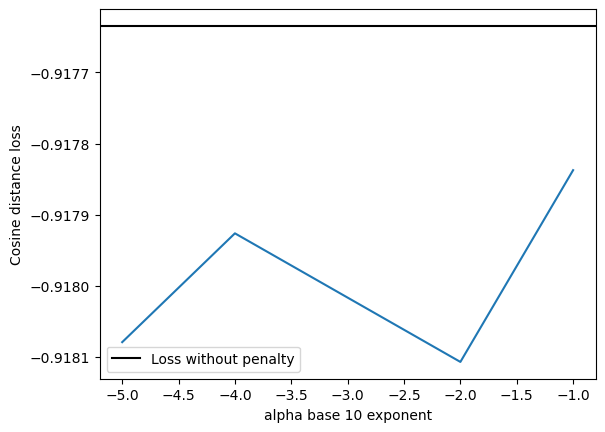

In [44]:
plt.plot([-1,-2,-4,-5],Losses)
plt.axhline(Loss,color = 'k', label="Loss without penalty")
plt.legend()
plt.xlabel("alpha base 10 exponent")
plt.ylabel("Cosine distance loss")
